MTG guild analysis (by Arseny Khakhalin). Forked from the general analysis script by Arseny Khakhalin and Bobby Mills.

This script assumes that the "Basic analysis" notebook was already run, and so both "basic_data" and "distances" CSV files are already saved.

Note that because the "Basic analysis" file lies in the root folder, and this one is currently kept in a subfolder, all local references are slightly different (in most cases, '../' is added).

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.manifold import MDS

In [2]:
from draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [3]:
# Alternatives: XLN, DOM, M19, GRN, RNA
setName = 'RNA'

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [5]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

# thisSet[list(thisSet.keys())[0]] # Full info for one card

Change the addresses below if you store data ini a different folder locally:

In [7]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv'
}

draftData = pd.read_csv('../'+dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

# draftData.head()
print('Loaded ', len(draftData['format']), " draft records.")

Loaded  88388  draft records.


In [8]:
# Read basic set data and card-to-card distances

df = pd.read_csv('basic_data_'+setName+'.csv')
df = df.set_index('name')

dist = np.genfromtxt('distances_'+setName+'.csv', delimiter=',')

rdata = pd.read_csv('R_output_'+setName+'.csv')
rdata = rdata.set_index('name')

In [9]:
# Set color code for each card
def colorIdentity(colorList,mode):
    row = ''
    # Color sequence for RAN set:
    colorTable = {'W':0 , 'UW':0.5, 'U': 1 , 'GU':1.5, 'G': 2 , 'GR':2.5, 'R':3 , 'BR':3.5, 'B':4, 'BW':4.5}
    
    # Concatenate all characters:
    for c in colorList:
        row += c    
    
    if row in colorTable:
        return colorTable[row]
    else:
        return 0 # For all-color combinations

Guids distribute our colors in a meaningful circle (for RNA: WUGRB), which means that we are working with circular statistics. To do circular statistics, we would typically work not with angular values themselves, but with their representations in a 2D vector space, as it allows vector averaging:
https://en.wikipedia.org/wiki/Mean_of_circular_quantities

Therefore, below we first create a special dataset that contains not only color angles ('colorv'), but also their representations on a 2D unit circle ('colorx' and 'colory'). "W" here contributes to $v=0$, and so $x=1$ and $y=0$.

In [10]:
df2 = df.join(rdata[['x','y']],how='inner',rsuffix='r') # Replace bad Python coords with good R ones
df2['x'] = df2['xr']
df2['y'] = df2['yr']
df2 = df2.drop(columns=['xr','yr'])

colorInfo = pd.DataFrame({'colorv' : [colorIdentity(thisSet[card]['colorIdentity'],'v') for card in list(df2.index)]},
                   list(df2.index))
colorInfo['colorx'] = np.cos(colorInfo['colorv']/5*2*np.pi)
colorInfo['colory'] = np.sin(colorInfo['colorv']/5*2*np.pi)

df2 = df2.join(colorInfo) # Add color code

#df2

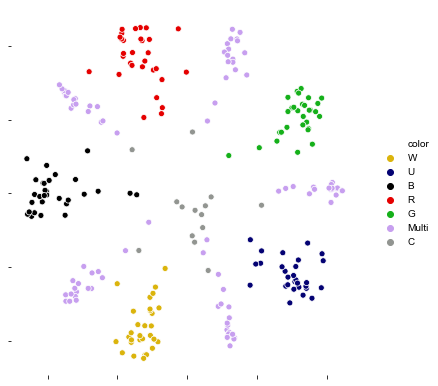

In [11]:
# Check if we can reproduce R plot

#%matplotlib inline

myPal = sns.xkcd_palette(["gold","deep blue","black","red","green","lavender","grey"])
s = sns.relplot(data=df2,x="x",y="y",hue="color",palette=myPal)
s.fig.set_size_inches(7,6)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

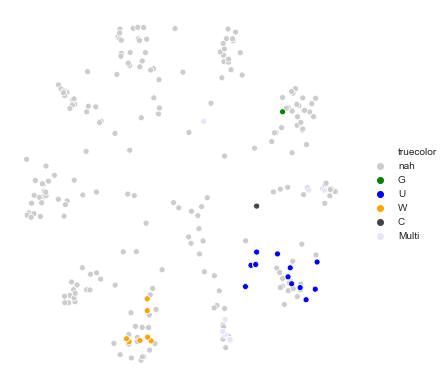

In [12]:
# Pick a deck, project it into the synergy plot

#%matplotlib inline

handToShow= 333

hand = draftData['human'].iloc[handToShow]
hand = fixName(hand).lower().split(',')

hand = pd.DataFrame({},list(hand)).join(df2,how="inner")
hand['truecolor'] = hand['color']

toplot = pd.concat([hand, df2.assign(truecolor='nah')])
toplot = toplot.iloc[::-1] # Reverse the dataframe, for plotting

myPal = {"W":"orange","U":"blue","B":"black","R":"red","G":"green","Multi":"lavender","C":"#444444","nah":"#cccccc"}
s = sns.relplot(data=toplot,x="x",y="y",hue="truecolor",palette=myPal)
s.fig.set_size_inches(7,6)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

In [19]:
# Prepare for the main loop: 

print('Expected time for full analysis: ', np.floor(len(draftData[player])/100/60), " min.");
# (Main loop curently runs about 1 s for 100 drafts)`

Expected time for full analysis:  14.0  min.


Main loop (may be very slow!)

In [39]:
draftCount = 0
player = 'human' # normally should be 'human', but can also be bot1 or another bot
deckColorM = [0]*len(draftData[player])
deckColorV = [0]*len(draftData[player])

ticTime = time.time()
for pile in draftData[player][0:10000]:
    pile = fixName(pile)
    pile = pile.lower()
    pile = pile.split(',')
    
    tempx = np.mean([df2.loc[pile[i]]['colorx'] for i in range(len(pile))])
    tempy = np.mean([df2.loc[pile[i]]['colory'] for i in range(len(pile))])
    
    deckColorM[draftCount] =  np.arctan(tempy/tempx)/(2*np.pi)*5 + 2.5*(tempx<0) + 5*(tempx>0 and tempy<0)
    deckColorV[draftCount] =  np.sqrt(-2*np.log(np.sqrt(tempx**2+tempy**2)))
    # Formula for circular standard deviation taken from here:
    # https://en.wikipedia.org/wiki/Directional_statistics#Moments
    
    draftCount = draftCount+1                 # For debugging
            

print("Time elapsed: ", time.time() - ticTime)
print(draftCount)

Time elapsed:  123.8050811290741
10000


In [40]:
print('Average color: ', deckColorM[handToShow])
print('Color deviation: ', deckColorV[handToShow])

Average color:  0.7551733871624358
Color deviation:  0.6549846213307604


Text(0,0.5,'Frequency')

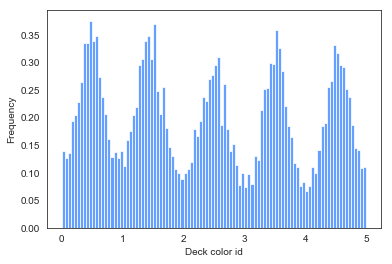

In [41]:
# deckColorId

fig, ax = plt.subplots()
n, bins, patches = plt.hist(deckColorId[0:10000], 100, density=True, facecolor=(0.2,0.5,1), alpha=0.75)
plt.xlabel('Deck color id')
plt.ylabel('Frequency') 

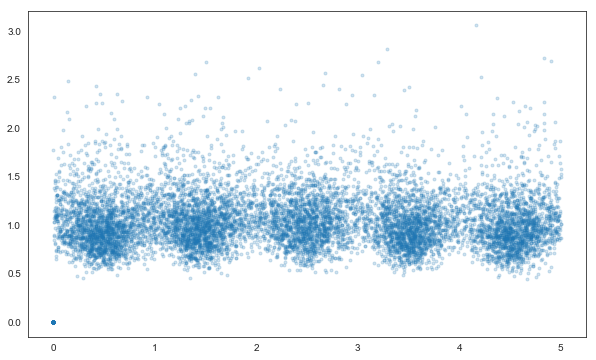

In [51]:
#%matplotlib inline
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.plot(deckColorM,deckColorV,'.',alpha=0.2)